# **Deep Fruit Detection in Orchards**
## Reproduced by

#### Agrim Sharma
#### Anitej Palakodeti - (5214068) Email: A.Palakodeti@student.tudelft.nl

# Introduction

This blog presents the reproduction of the paper [Deep Fruit Detection in Orchards](https://arxiv.org/abs/1610.03677) by Suchet Bargoti and James Underwood. The paper focuses on using a Faster Region Based Convolutional Neural Network (R-CNN) for object detection of fruits in orchards in Australia. The paper achieves strong results for the detection of apples, mangoes and almonds. It also includes data augmentation in the training process to show how the precision improves. In this blog we aim to explain various aspects of the paper through the means of our own experiments and reproduction.

Our reproduction focuses only on the detection of mangoes using a VGG-16 Convolutional Neural Network (CNN) as the backbone of the Faster R-CNN for object detection.  The dataset comprises directories for each fruit and each directory is further divided into a list of images and corresponding csv files with dimensions of the bounding boxes for each image. The dataset used is available publicly and required minor pre-processing. Firstly, the list of images for training and testing had to be saved in separate directories by reading a text file with a list of image names and corresponding csv file names. The csv files of the images were concatenated for training and testing respectively. The features of the bounding boxes were then transformed to store the extreme values of the positions for the x and y coordinates of the images. For our reproduction we followed the highly detailed tutorial provided by [PyTorch for Object Detection](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial) and Maximilian Beckers’ tutorial on [Raccoon Detection](https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae) which were both very useful.

The entire architecture of the Faster RCNN can be seen in the image below, with the following sections describing the function of each component in the pipeline.
![picture](https://drive.google.com/uc?export=view&id=1V5Onl-xz9prfOVwum7xCEf9jQWddlqIa)

# Convolutional Neural Network
A CNN layer consists of several filters that perform 2D convolution on the input images, across all the image channels, each generating a feature map. These feature maps are then stacked back to back to create another image with N channels where N is the number of filters. This new image is then used as the input for the next layer, increasing the complexity and flexibility of the features that are detected by the CNN overall. In the project, we are using a VGG-16 CNN to generate these feature maps, which are the input for the Region Proposal Network.

![picture](https://drive.google.com/uc?export=view&id=1uoG6gKfAhE9u4I6TS6n0eLhphBXRGz5P)


# Region Proposal Network

As the name states, this part of the Faster R-CNN proposes regions for classification into foreground or background. Each point on the feature map is considered to be an anchor with a few specified aspect ratios and sizes for its bounding boxes. This helps in detecting objects of varying shapes and sizes. In our project, we used the anchor sizes 64, 128, and 256, for aspect ratios 0.5, 1, 2. The sizes were chosen based on the fact that the objects in question, mangoes, do not take up a large part of the image, so smaller anchor sizes would be beneficial. This hypothesis was then confirmed by a quick test where we took a few sets of 3 different anchor sizes and trained our Faster R-CNN on the data. The aforementioned sizes had the best result. The aspect ratios however were taken as the standard values we came across while researching the topic.

The anchors are used by the RPN as a reference for predicting the coordinates of the objects within the image, with each anchor generating a bounding box of the different sizes and aspect ratios mentioned above.

The Region Proposal Network then takes all of these reference boxes and presents a set of proposals that could be objects in the image. The RPN generates two results for each anchor. The first is a score representing how likely the anchor is to be an object, which is used to select the best few anchors. The next result takes the best anchors and uses bounding box regression to modify the anchors so they can fit the object better.

![picture](https://drive.google.com/uc?export=view&id=1PbXME8N71LrA8N7RTjfmzaLhwUl_-FB7)



# Region of Interest Pooling

In this stage, we have several proposals for regions with "objects" without actually knowing what object that is. We still need to classify these bounding boxes. 
To do this, the Faster R-CNN maps the proposals onto the existing feature map, and crops them to obtain a feature map for each proposal.

![picture](https://drive.google.com/uc?export=view&id=1mvafKP3MwtwxzotLRYlLAcwey4BkEyGl)

# Region Based Convolutional Neural Network
Finally, an R-CNN takes the proposed feature maps and flattens them out and uses fully connected layers to generate the classification for the feature maps. The fully connected layers also predicts the adjusted coordinates for bounding boxes so they fit around the classified object better.

![picture](https://drive.google.com/uc?export=view&id=1jF-vF6C34-Sb6ShHYfRPUMgjTPFfhBgK)

All of the parts of the Faster R-CNN described above can be used through the following code.

```
def get_model(num_classes):
    
    #Selecting VGG16 faster-RCNN as the backbone model
    backbone = torchvision.models.vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(sizes=(( 64, 128,256),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)
    
    model = FasterRCNN(backbone,num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler)

    return model
```



# Training

To train the Faster R-CNN model we used Stochastic Gradient Descent with Momentum as the optimizer and the model was trained for 10000 iterations for every batch size. As the hyperparameters for the optimizers were not provided in the paper, the learning rate, weight decay and momentum values for the optimizer were set as the default values as per the PyTorch tutorial. In addition, the learning rate was scheduled to reduce by 10 times after a certain number of epochs. The learning rate scheduler was tuned individually for every batch size when training. This is because small batch sizes were trained for higher number of epochs and if a low step size for scheduling was assigned, the learning rate was heavily penalised and the optimal value would never be reached.



Given below is the training configuration and parameters

```
device = torch.device('cuda:0')
# Our dataset has two classes only - mango and not mango
num_classes = 2
# Get the model using our helper function
model = get_model(num_classes)
# Move model to the right device
model.to(device)
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# A learning rate scheduler which decreases the learning rate by 10 times every 5 epochs. This value changes based on the dataset size

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
```

The training loop is provided as follows. In this code snippet, a batch size of 1000 images is trained for 10 epochs and the model is evaluated on the test set every epoch to obtain the precision and recall values.

```
# Number of epochs to train for
num_epochs = 10

for epoch in range(num_epochs):

   # train for one epoch, printing every 500 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)

    # update the learning rate
    lr_scheduler.step()

    # Evaluate the model on test set every epochs to check precision and recall
    evaluate(model, data_loader_test, device=device)

# Evaluate on the test dataset after training
evaluate(model, data_loader_test, device=device)
```




# Results

The Faster R-CNN was trained with the same dataset used in the paper. To replicate the experiment, we limited the size of the dataset that the Faster R-CNN was allowed to train on, and noted the increase in accuracy as the dataset size increased. This can be seen in the graph below which is a very similar plot as Figure 3 in the paper.

The precision value obtained is based on the Intersection over Union (IoU) metric. This metric take the ratio of the number of pixels found in the intersection of the predicted area of bounding boxes and ground truth to the union of the predicted and ground truth boxes. In other words, it calculates the ratio of the number pixels in common between the target and prediction to the total number of pixels across both the target and prediction. 

The precision is reported for IoU values above the threshold of 0.2 as per the paper.


From this graph we can observe that as the size of the training set increases, the precision values increase accordingly. The precision values however stagnate and reach similar values when the batch size is large and approaches the size of the entire training set.

![picture](https://drive.google.com/uc?export=view&id=1M15cNHVWnlTKSdJn16RbD-dYKH2dfoQ7)


Once we were able to match the learning curve of the model in the paper (Figure 3), we proceeded to perform data augmentation in order to replicate Figure 5 in the paper. To do this, we had to modify the existing transforms.py code in pytorch's object detection module to perform the data transformation on the bounding boxes as well as the images. We used three augmentations in total: Horizontal Flip, Grayscale, and Resize. The paper introduces data augmentation for Flip, Scale, and Flip-Scale where the two transformations are combined. Grayscale is an additional data augmentation not in the paper as we were keen on exploring the results this transformation would produce. The code for the same is presented below.



```
class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target
```



```
class RandomGrayscale(object):
    """Randomly convert image to grayscale with a probability of p (default 0.1).

    Args:
        p (float): probability that image should be converted to grayscale.

    Returns:
        PIL Image: Grayscale version of the input image with probability p and unchanged
        with probability (1-p).
        - If input image is 1 channel: grayscale version is 1 channel
        - If input image is 3 channel: grayscale version is 3 channel with r == g == b

    """

    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, img, target):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.

        Returns:
            PIL Image: Randomly grayscaled image.
        """
        num_output_channels = 1 if img.mode == 'L' else 3
        if random.random() < self.p:
            img = F.to_grayscale(img, num_output_channels=num_output_channels)
        return img, target
```



```
class Resize(object):
    """Resize the input PIL Image to the given size.

    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, Iterable) and len(size) == 2)

        # Resize to (300,300)
        self.size = 300
        self.interpolation = interpolation

    def __call__(self, img,target):
        """
        Args:
            img (PIL Image): Image to be scaled.

        Returns:
            PIL Image: Rescaled image.
        """
        
        val1 = F.resize(img, self.size, self.interpolation)
        
        boxes = target["boxes"]
        boxes = boxes*0.6
        target["boxes"] = boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        target["area"] = area
        
        return val1, target
```

We obtained the following results for data augmentation:
![picture](https://drive.google.com/uc?export=view&id=1Lekobe_EZUqbSKl57sNZc7kNdYiVgsC5)


The figure above shows that transformations have a considerable difference to the training of the model as different precision values are obtained for the same batch sizes. 

For a relatively small batch size of upto 200, the Flip transformation results in highest precision values. However, for a larger batch sizes from 1000 and above, the precision values for the Grayscale transformation are the highest. One can observe that for all transformations, there is a steep increase in precision upto a certain batch size for all transformations and a gradual increase thereafter. When compared with Figure 5 of the paper, there are some noticeable discepancies; the first being that the model trained without any augmentation has lowest precision for all batch sizes and that the flip-scale transformation achieves highest precision scores for all batch sizes. In our case however, the model without any transformation does fairly well for all batch sizes and the model with the flip-scale transformation does not outperform the other models. We speculate that the reason for this could be the fact that the authors of the paper train the models on different parameters to us thereby leading to the differences.

The Table below shows the F1-Scores obtained for the various model when trained on the entire training set with and without augmentations. Our models have a higher F1-Score when compared with Table II of the paper.

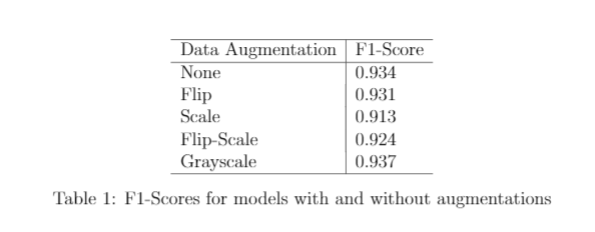

# Predictions
The trained models generalise well on the test dataset overall. However, a limitation with the model is that it generates false positives when mangoes on the ground are identified. The ground truth objects are mangoes which are only found on trees.

Given below is the raw image from the test set of mangoes on a tree

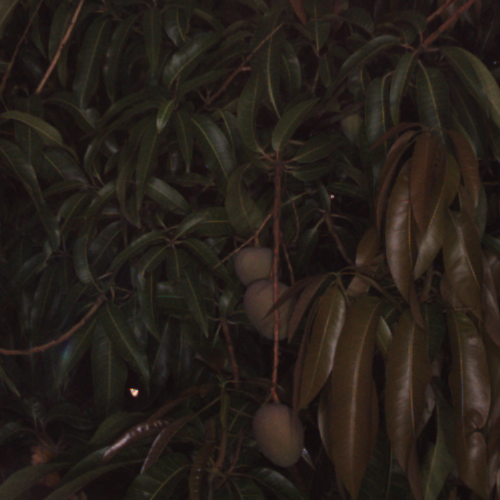

This image shows all the regions of interest which are considered to be mangoes.

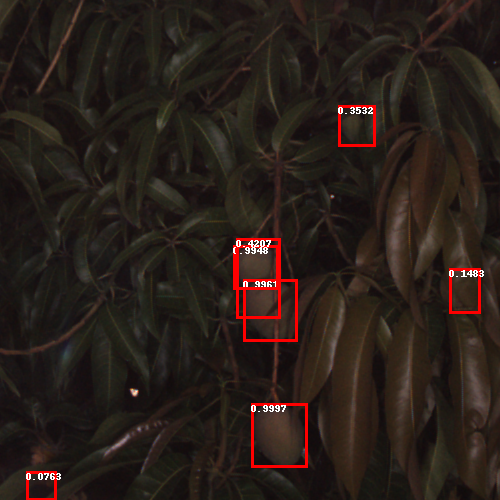

The image below shows the mangoes being detected. The green boxes are the ground truth values and the red boxes are our model's predictions. The red boxes are drawn (prediction made) only if a sufficient score IoU score of greater than 0.8 is achieved. Not all the regions of interest pass the threshold.




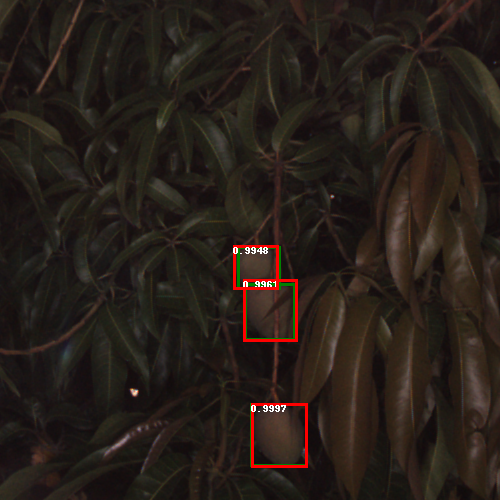

Image with mangoes on the ground and on the tree

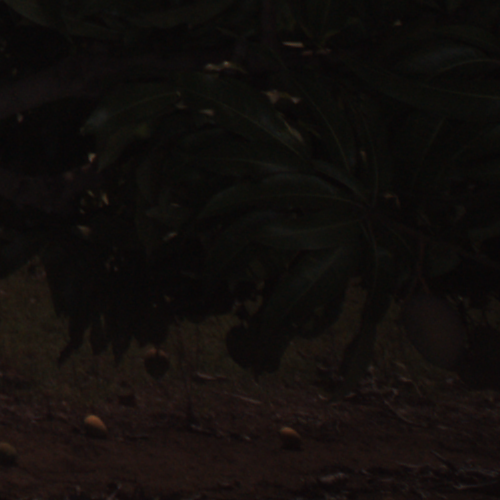

Model detecting mangoes on the tree as well as the ground thereby resulting in a false positive. In this scenario a false negative is also displayed where a mango is not detected.

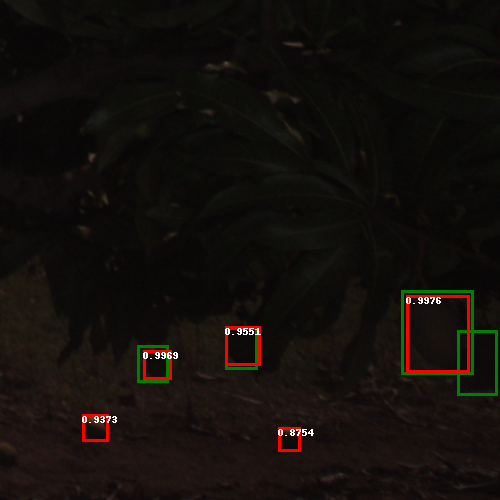

# Conclusion

We attempted to reproduce the paper Deep Fruit Detection in Orchards and were successfully able to reproduce Figures 2, 3 and 5 from the original paper for the detection of mangoes. We also reproduced Table II from the paper and with a better F1-Score. In addition, we introduced a data augmentation technique of Random Grayscaling which was not explored in the paper and this achieves the highest precision and F1-Score when trained on the entire dataset. However, we noticed a few limitations in our reproduction where the model falsely identifies mangoes present on the ground. Due to the parameters for optimization not being provided in the paper, we were unable to reproduce the exact figures in the paper but our results are comparable and similar.

# Individual Contributions

*   Agrim - Model configuration of anchor size selection and region of interest pooling. Fine-tuning the learning rate scheduler for various batch sizes. Implemented the Random Grayscale and Flip transformations. Trained the models and reported results for the following data augmentations : Flip and Random Grayscale. Plotting of results to reproduce Figure 3 and Figure 5.
*   Anitej - Preprocessing and preparing the data, constructing the pipeline from dataset creation and loading to training and evaluation. Implemented the Scale transformation. Trained the models and reported results for the following data augmentations : No augmentation, Scale and Flip-Scale.

Blogpost writing was split equally.


